# 17. 새로운 데이터 합성을 위한 생성적 적대 신경망

## 17.1 생성적 적대 신경망 소개

### 17.2.2 생성자와 판별자 신경망 구현

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## 생성자 함수를 정의한다:
def make_generator_network(
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units=784):
    
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(units=num_hidden_units, use_bias=False))
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dense(units=num_output_units, activation='tanh'))
    return model
                  
## 판별자 함수를 정의한다:
def make_discriminator_network(
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units=1):
    
    model = tf.keras.Sequential()
    for i in range(num_hidden_layers):
        model.add(
            tf.keras.layers.Dense(units=num_hidden_units))
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(rate=0.5))
    
    model.add(tf.keras.layers.Dense(units=num_output_units, activation=None))
    return model

In [3]:
# MNIST 이미지가 28 X 28 이므로,
image_size = (28, 28)
z_size = 20
mode_z = 'uniform' # 'uniform' vs 'normal'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100
tf.random.set_seed(1)
gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size))

gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2000      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               79184     
                                                                 
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [4]:
disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size)
disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


### 17.2.3 훈련 데이터셋 정의

In [7]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.reshape(image, [-1])
    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image



mnist_trainset = mnist['train']

print('전처리 전:  ')
example = next(iter(mnist_trainset))['image']
print('dtype: ', example.dtype, ' 최소: {} 최대: {}'.format(np.min(example), np.max(example)))

mnist_trainset = mnist_trainset.map(preprocess)

print('전처리 후:  ')
example = next(iter(mnist_trainset))[0]
print('dtype: ', example.dtype, ' 최소: {} 최대: {}'.format(np.min(example), np.max(example)))

전처리 전:  
dtype:  <dtype: 'uint8'>  최소: 0 최대: 255
전처리 후:  
dtype:  <dtype: 'float32'>  최소: -0.8737728595733643 최대: 0.9460210800170898


In [8]:
mnist_trainset = mnist_trainset.batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))
print('input-z -- 크기:', input_z.shape)
print('input-real -- 크기:', input_real.shape)

g_output = gen_model(input_z)
print('생성자 출력 -- 크기:', g_output.shape)

d_logits_real = disc_model(input_real)
d_logits_fake = disc_model(g_output)
print('판별자 (진짜) -- 크기:', d_logits_real.shape)
print('판별자 (가짜) -- 크기:', d_logits_fake.shape)

input-z -- 크기: (32, 20)
input-real -- 크기: (32, 784)
생성자 출력 -- 크기: (32, 784)
판별자 (진짜) -- 크기: (32, 1)
판별자 (가짜) -- 크기: (32, 1)


### 17.2.4 GAN 모델 훈련하기

In [9]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
## 생성자 손실
g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('생성자 손실: {:.4f}'.format(g_loss))

생성자 손실: 0.7019


In [10]:
## 판별자 손실
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)
d_loss_real = loss_fn(y_true=d_labels_real,
                      y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake,
                      y_pred=d_logits_fake)
print('판별자 손실: 진짜 {:.4f} 가짜 {:.4f}'.format(d_loss_real.numpy(), d_loss_fake.numpy()))

판별자 손실: 진짜 1.4667 가짜 0.6871


In [13]:

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## 생성자 손실
g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)
print('생성자 손실: {:.4f}'.format(g_loss))

## 판별자 손실
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_logits_fake)
print('판별자 손실: 진짜 {:.4f} 가짜 {:.4f}'
      .format(d_loss_real.numpy(), d_loss_fake.numpy()))

생성자 손실: 0.7019
판별자 손실: 진짜 1.4667 가짜 0.6871


In [9]:
import tensorflow as tf
print(tf.__version__)

print("GPU 여부:", len(tf.config.list_physical_devices('GPU')) > 0)

if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name = 'cpu:0'
    
print(device_name)

2.10.1
GPU 여부: True
/device:GPU:0


In [16]:
import time

num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)


if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))


def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

## 데이터셋 준비
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## 모델 준비
with tf.device(device_name):
    gen_model = make_generator_network(
        num_hidden_layers=gen_hidden_layers, 
        num_hidden_units=gen_hidden_size,
        num_output_units=np.prod(image_size))
    gen_model.build(input_shape=(None, z_size))

    disc_model = make_discriminator_network(
        num_hidden_layers=disc_hidden_layers,
        num_hidden_units=disc_hidden_size)
    disc_model.build(input_shape=(None, np.prod(image_size)))

## 손실 함수와 옵티마이저:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## 생성자 손실을 계산합니다
        with tf.GradientTape() as g_tape:
            g_output = gen_model(input_z)
            d_logits_fake = disc_model(g_output, training=True)
            labels_real = tf.ones_like(d_logits_fake)
            g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)
            
        # g_loss의 그래디언트를 계산합니다
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        
        # 최적화: 그래디언트를 적용합니다
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        ## 판별자 손실을 계산합니다
        with tf.GradientTape() as d_tape:
            d_logits_real = disc_model(input_real, training=True)

            d_labels_real = tf.ones_like(d_logits_real)
            
            d_loss_real = loss_fn(
                y_true=d_labels_real, y_pred=d_logits_real)

            d_logits_fake = disc_model(g_output, training=True)
            d_labels_fake = tf.zeros_like(d_logits_fake)

            d_loss_fake = loss_fn(
                y_true=d_labels_fake, y_pred=d_logits_fake)

            d_loss = d_loss_real + d_loss_fake

        ## d_loss의 그래디언트를 계산합니다
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        
        ## 최적화: 그래디언트를 적용합니다
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
                           
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
        
        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))        
    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        '에포크 {:03d} | 시간 {:.2f} min | 평균 손실 >>'
        ' 생성자/판별자 {:.4f}/{:.4f} [판별자-진짜: {:.4f} 판별자-가짜: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())

에포크 001 | 시간 0.37 min | 평균 손실 >> 생성자/판별자 2.8947/0.2674 [판별자-진짜: 0.0258 판별자-가짜: 0.2416]
에포크 002 | 시간 0.72 min | 평균 손실 >> 생성자/판별자 5.0962/0.3137 [판별자-진짜: 0.0988 판별자-가짜: 0.2149]
에포크 003 | 시간 1.06 min | 평균 손실 >> 생성자/판별자 3.5007/0.6438 [판별자-진짜: 0.2854 판별자-가짜: 0.3584]
에포크 004 | 시간 1.43 min | 평균 손실 >> 생성자/판별자 2.3375/0.8574 [판별자-진짜: 0.4349 판별자-가짜: 0.4225]
에포크 005 | 시간 1.81 min | 평균 손실 >> 생성자/판별자 2.1633/0.7642 [판별자-진짜: 0.4313 판별자-가짜: 0.3329]
에포크 006 | 시간 2.18 min | 평균 손실 >> 생성자/판별자 2.0386/0.8751 [판별자-진짜: 0.4738 판별자-가짜: 0.4014]
에포크 007 | 시간 2.57 min | 평균 손실 >> 생성자/판별자 1.5990/0.9337 [판별자-진짜: 0.5092 판별자-가짜: 0.4245]
에포크 008 | 시간 2.95 min | 평균 손실 >> 생성자/판별자 1.6394/0.9718 [판별자-진짜: 0.5263 판별자-가짜: 0.4455]
에포크 009 | 시간 3.31 min | 평균 손실 >> 생성자/판별자 1.4747/1.0155 [판별자-진짜: 0.5554 판별자-가짜: 0.4601]
에포크 010 | 시간 3.70 min | 평균 손실 >> 생성자/판별자 1.3679/1.0615 [판별자-진짜: 0.5715 판별자-가짜: 0.4900]
에포크 011 | 시간 4.09 min | 평균 손실 >> 생성자/판별자 1.3620/1.0797 [판별자-진짜: 0.5726 판별자-가짜: 0.5071]
에포크 012 | 시간 4.47 min | 평균 손실 >> 생성자/판별자 1.

에포크 095 | 시간 43.28 min | 평균 손실 >> 생성자/판별자 0.9221/1.3219 [판별자-진짜: 0.6621 판별자-가짜: 0.6598]
에포크 096 | 시간 43.79 min | 평균 손실 >> 생성자/판별자 0.9064/1.3129 [판별자-진짜: 0.6589 판별자-가짜: 0.6540]
에포크 097 | 시간 44.31 min | 평균 손실 >> 생성자/판별자 0.9145/1.3295 [판별자-진짜: 0.6656 판별자-가짜: 0.6639]
에포크 098 | 시간 44.84 min | 평균 손실 >> 생성자/판별자 0.8747/1.3345 [판별자-진짜: 0.6690 판별자-가짜: 0.6655]
에포크 099 | 시간 45.35 min | 평균 손실 >> 생성자/판별자 0.9416/1.3130 [판별자-진짜: 0.6595 판별자-가짜: 0.6535]
에포크 100 | 시간 45.88 min | 평균 손실 >> 생성자/판별자 0.9311/1.3117 [판별자-진짜: 0.6588 판별자-가짜: 0.6529]


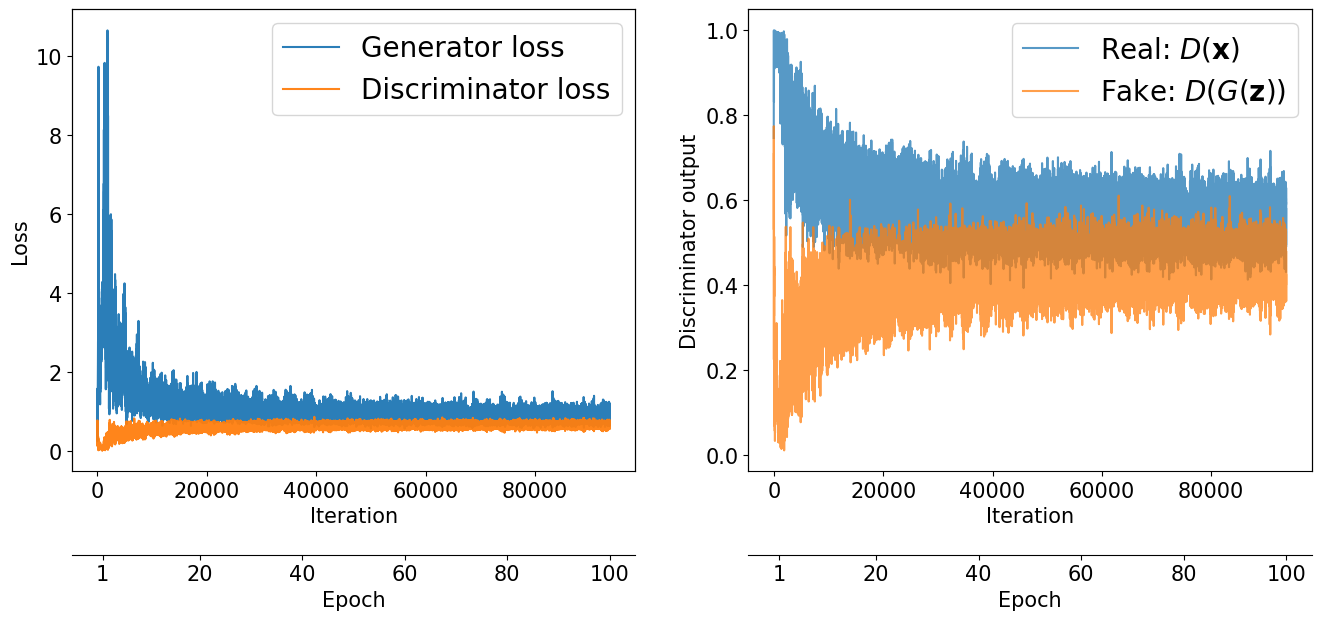

In [18]:
import itertools
fig = plt.figure(figsize=(16, 6))
## 손실 그래프
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos= [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

## 판별자의 출력
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.show()

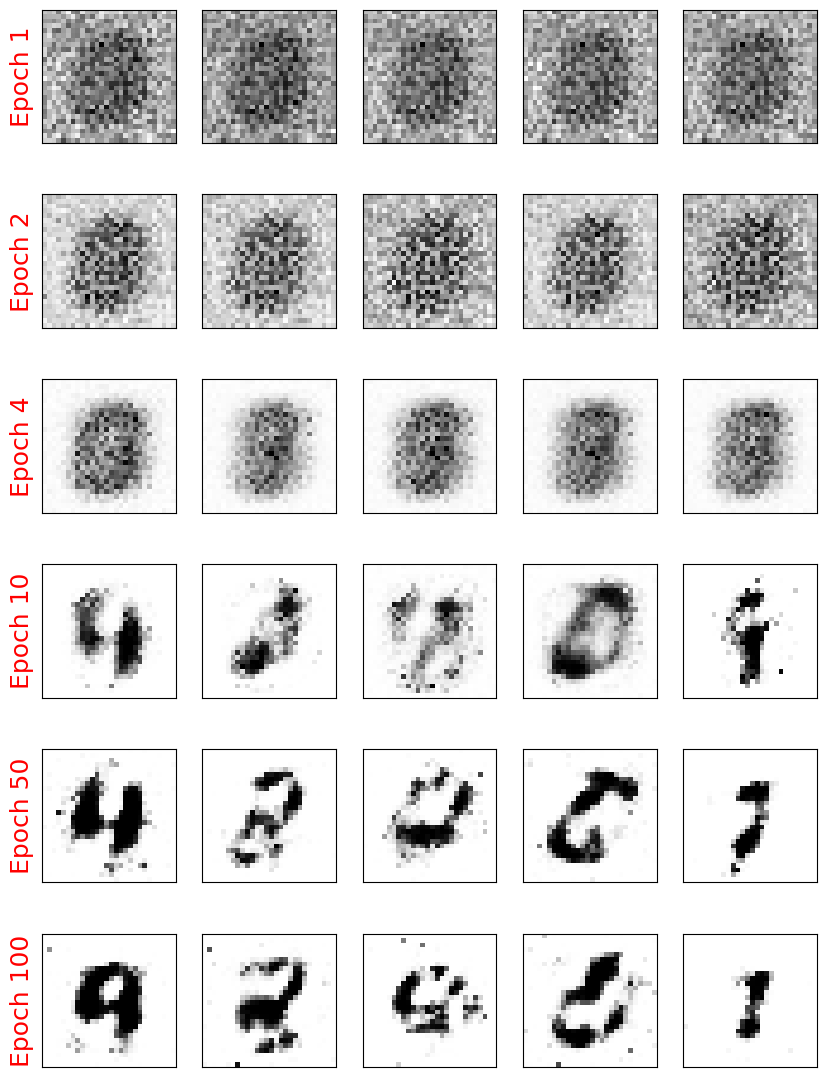

In [19]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()

## 17.3 합성곱 GAN과 바서슈타인 GAN으로 합성 이미지 품질 높이기

In [3]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def make_dcgan_generator(
        z_size=20, 
        output_size=(28, 28, 1),
        n_filters=128, 
        n_blocks=2):
    size_factor = 2**n_blocks
    hidden_size = (
        output_size[0]//size_factor, 
        output_size[1]//size_factor
    )
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(z_size,)),
        
        tf.keras.layers.Dense(
            units=n_filters*np.prod(hidden_size), 
            use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape(
            (hidden_size[0], hidden_size[1], n_filters)),
    
        tf.keras.layers.Conv2DTranspose(
            filters=n_filters, kernel_size=(5, 5), strides=(1, 1),
            padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
        
    nf = n_filters
    for i in range(n_blocks):
        nf = nf // 2
        model.add(
            tf.keras.layers.Conv2DTranspose(
                filters=nf, kernel_size=(5, 5), strides=(2, 2),
                padding='same', use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
                
    model.add(
        tf.keras.layers.Conv2DTranspose(
            filters=output_size[2], kernel_size=(5, 5), 
            strides=(1, 1), padding='same', use_bias=False, 
            activation='tanh'))
        
    return model

def make_dcgan_discriminator(
        input_size=(28, 28, 1),
        n_filters=64, 
        n_blocks=2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size),
        tf.keras.layers.Conv2D(
            filters=n_filters, kernel_size=5, 
            strides=(1, 1), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])
    
    nf = n_filters
    for i in range(n_blocks):
        nf = nf*2
        model.add(
            tf.keras.layers.Conv2D(
                filters=nf, kernel_size=(5, 5), 
                strides=(2, 2),padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.3))
        
    model.add(tf.keras.layers.Conv2D(
            filters=1, kernel_size=(7, 7), padding='valid'))
    
    model.add(tf.keras.layers.Reshape((1,)))
    
    return model

In [5]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)
def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image

In [6]:
gen_model = make_dcgan_generator()
gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              125440    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        409600    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [7]:
disc_model = make_dcgan_discriminator()
disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       204928    
                                                                 
 batch_normalization_5 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)      

In [10]:
num_epochs = 100
batch_size = 128
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
lambda_gp = 10.0

tf.random.set_seed(1)
np.random.seed(1)

## 데이터셋 준비
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## 모델 생성
with tf.device(device_name):
    gen_model = make_dcgan_generator()
    gen_model.build(input_shape=(None, z_size))
    gen_model.summary()

    disc_model = make_dcgan_discriminator()
    disc_model.build(input_shape=(None, np.prod(image_size)))
    disc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              125440    
                                                                 
 batch_normalization_7 (Batc  (None, 6272)             25088     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 7, 7, 128)        409600    
 ranspose)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 7, 7, 128)       

In [11]:
import time


## 옵티마이저:
g_optimizer = tf.keras.optimizers.Adam(0.0002)
d_optimizer = tf.keras.optimizers.Adam(0.0002)

if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

all_losses = []
epoch_samples = []

start_time = time.time()

for epoch in range(1, num_epochs+1):
    epoch_losses = []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            g_output = gen_model(input_z, training=True)
            
            d_critics_real = disc_model(input_real, training=True)
            d_critics_fake = disc_model(g_output, training=True)

            ## 생성자 손실을 계산합니다:
            g_loss = -tf.math.reduce_mean(d_critics_fake)

            ## 판별자 손실을 계산합니다:
            d_loss_real = -tf.math.reduce_mean(d_critics_real)
            d_loss_fake =  tf.math.reduce_mean(d_critics_fake)
            d_loss = d_loss_real + d_loss_fake

            ## 그래디언트 페널티:
            with tf.GradientTape() as gp_tape:
                alpha = tf.random.uniform(
                    shape=[d_critics_real.shape[0], 1, 1, 1], 
                    minval=0.0, maxval=1.0)
                interpolated = (
                    alpha*input_real + (1-alpha)*g_output)
                gp_tape.watch(interpolated)
                d_critics_intp = disc_model(interpolated)
            
            grads_intp = gp_tape.gradient(
                d_critics_intp, [interpolated,])[0]
            grads_intp_l2 = tf.sqrt(
                tf.reduce_sum(tf.square(grads_intp), axis=[1, 2, 3]))
            grad_penalty = tf.reduce_mean(tf.square(grads_intp_l2 - 1.0))
        
            d_loss = d_loss + lambda_gp*grad_penalty
        
        ## 최적화: 그래디언트를 계산하고 적용합니다
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
        
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
                    
    all_losses.append(epoch_losses)
    
    print('에포크 {:-3d} | 시간 {:.2f} min | 평균 손실 >>'
          ' 생성자/판별자 {:6.2f}/{:6.2f} [판별자-진짜: {:6.2f} 판별자-가짜: {:6.2f}]'
          .format(epoch, (time.time() - start_time)/60, 
                  *list(np.mean(all_losses[-1], axis=0)))
    )
    
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy()
    )

에포크   1 | 시간 1.00 min | 평균 손실 >> 생성자/판별자 117.60/-179.89 [판별자-진짜: -125.26 판별자-가짜: -117.60]
에포크   2 | 시간 1.87 min | 평균 손실 >> 생성자/판별자 114.17/-126.08 [판별자-진짜: -95.20 판별자-가짜: -114.17]
에포크   3 | 시간 2.74 min | 평균 손실 >> 생성자/판별자 100.39/-59.28 [판별자-진짜: -51.75 판별자-가짜: -100.39]
에포크   4 | 시간 3.60 min | 평균 손실 >> 생성자/판별자  46.09/-16.51 [판별자-진짜: -18.39 판별자-가짜: -46.09]
에포크   5 | 시간 4.46 min | 평균 손실 >> 생성자/판별자  38.47/-21.91 [판별자-진짜: -17.11 판별자-가짜: -38.47]
에포크   6 | 시간 5.37 min | 평균 손실 >> 생성자/판별자  42.62/-33.71 [판별자-진짜:  -3.98 판별자-가짜: -42.62]
에포크   7 | 시간 6.29 min | 평균 손실 >> 생성자/판별자  39.32/-16.49 [판별자-진짜:  -3.00 판별자-가짜: -39.32]
에포크   8 | 시간 7.20 min | 평균 손실 >> 생성자/판별자  51.57/-48.72 [판별자-진짜: -11.24 판별자-가짜: -51.57]
에포크   9 | 시간 8.17 min | 평균 손실 >> 생성자/판별자  62.25/-32.58 [판별자-진짜:  -6.08 판별자-가짜: -62.25]
에포크  10 | 시간 9.13 min | 평균 손실 >> 생성자/판별자  54.73/-27.48 [판별자-진짜:  24.16 판별자-가짜: -54.73]
에포크  11 | 시간 10.08 min | 평균 손실 >> 생성자/판별자  74.21/-67.36 [판별자-진짜: -16.60 판별자-가짜: -74.21]
에포크  12 | 시간 10.99 min | 평균 손실 >> 생성

에포크  92 | 시간 90.76 min | 평균 손실 >> 생성자/판별자 4399.09/-1432.94 [판별자-진짜: 2896.75 판별자-가짜: -4399.09]
에포크  93 | 시간 91.93 min | 평균 손실 >> 생성자/판별자 4488.58/-1522.85 [판별자-진짜: 2925.16 판별자-가짜: -4488.58]
에포크  94 | 시간 93.10 min | 평균 손실 >> 생성자/판별자 4811.46/-1578.17 [판별자-진짜: 3104.38 판별자-가짜: -4811.46]
에포크  95 | 시간 94.27 min | 평균 손실 >> 생성자/판별자 2395.35/-989.42 [판별자-진짜: 1373.98 판별자-가짜: -2395.35]
에포크  96 | 시간 95.34 min | 평균 손실 >> 생성자/판별자 5094.52/-1589.92 [판별자-진짜: 3412.06 판별자-가짜: -5094.52]
에포크  97 | 시간 96.41 min | 평균 손실 >> 생성자/판별자 5293.19/-1665.06 [판별자-진짜: 3523.87 판별자-가짜: -5293.19]
에포크  98 | 시간 97.48 min | 평균 손실 >> 생성자/판별자 5227.51/-1565.53 [판별자-진짜: 3507.65 판별자-가짜: -5227.51]
에포크  99 | 시간 98.55 min | 평균 손실 >> 생성자/판별자 5485.15/-1655.09 [판별자-진짜: 3742.88 판별자-가짜: -5485.15]
에포크 100 | 시간 99.63 min | 평균 손실 >> 생성자/판별자 5405.84/-1656.36 [판별자-진짜: 3575.63 판별자-가짜: -5405.84]


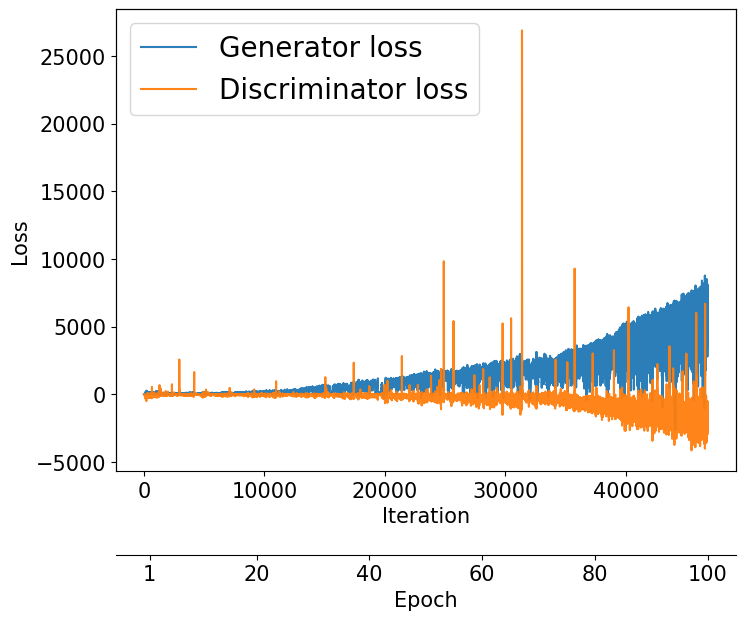

In [12]:
import itertools


fig = plt.figure(figsize=(8, 6))

## 손실 그래프
ax = fig.add_subplot(1, 1, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1] for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos   = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.show()

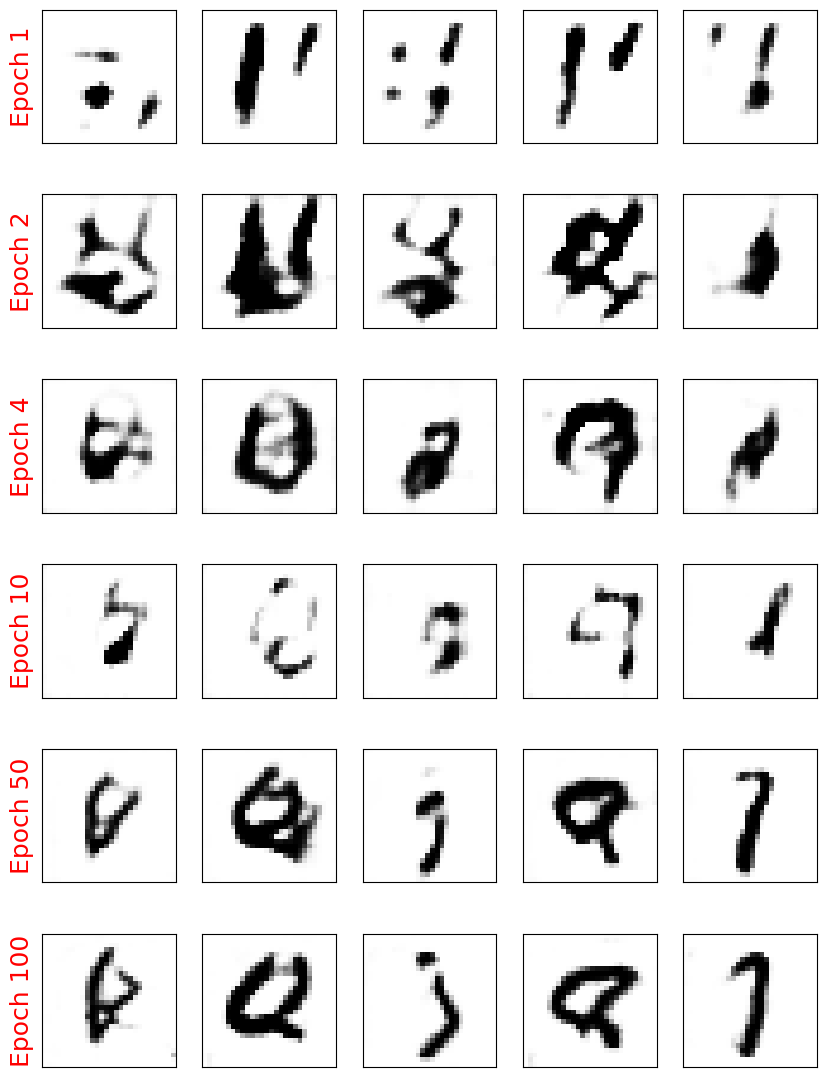

In [13]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()